In [2]:
import numpy as np
import matplotlib.pyplot as plt   
# import the Spin-Boson Model Simulation Class
from qclab.models.spin_boson import SpinBosonModel

input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
model = SpinBosonModel(input_params = input_params)

model.num_trajs = 400
model.tmax=40
model.dt_output=0.1
model.dt=0.01

model.wf_db = np.zeros((model.num_states),dtype=complex)
# initialize a quantum state in the upper state
model.wf_db[0] = 1

num_seeds = 20*model.batch_size
seeds = np.arange(0, num_seeds)

# import the coherent fewest-switches surface hopping dynamics Algorithm Class
from qclab.recipes import CoherentFewestSwitchesSurfaceHoppingDynamicsRecipe
recipe_cfssh = CoherentFewestSwitchesSurfaceHoppingDynamicsRecipe(model)



# import the serial driver 
from qclab.drivers.serial_driver import dynamics_serial
# import the simulation data class
import qclab.simulation as simulation


data_cfssh = dynamics_serial(recipe=recipe_cfssh, model = model, seeds = seeds, ncpus=1, data = simulation.Data())

  0%|          | 0/20 [00:01<?, ?it/s]


TypeError: SpinBosonModel.__init__.<locals>.h_q() missing 1 required positional argument: 'state'

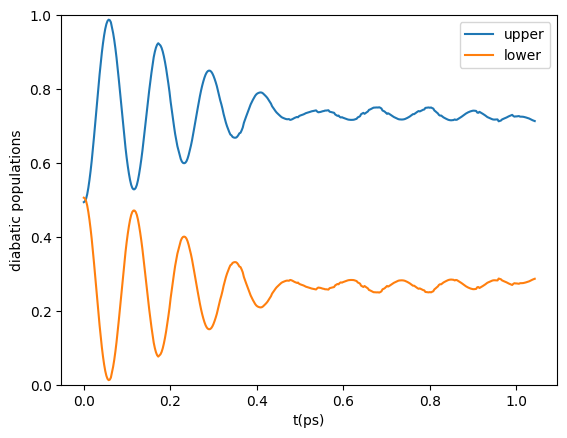

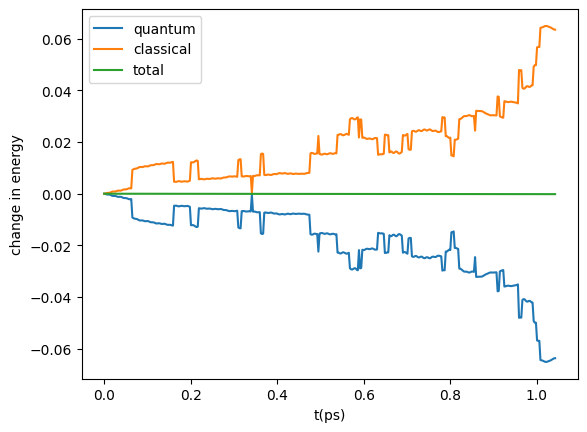

In [ ]:
ntraj =  num_seeds
pops_cfssh = np.real(np.einsum('nii->ni',data_cfssh.data_dic['dm_db']))/ntraj
t_ps = data_cfssh.data_dic['t'] * 0.0260677 /ntraj
e_q = data_cfssh.data_dic['e_q']/ntraj
e_c = data_cfssh.data_dic['e_c']/ntraj

plt.plot(t_ps, pops_cfssh[:,0], label='upper')
plt.plot(t_ps, pops_cfssh[:,1], label='lower')
plt.ylabel('diabatic populations')
plt.xlabel('t(ps)')
plt.legend()
plt.ylim([0,1])
plt.savefig('pops_sb_cfssh.pdf')
plt.show()

plt.plot(t_ps, np.real(e_q - e_q[0]), label='quantum')
plt.plot(t_ps, np.real(e_c - e_c[0]), label='classical')
plt.plot(t_ps, np.real(e_c - e_c[0] + e_q - e_q[0]), label='total')
plt.ylabel('change in energy')
plt.xlabel('t(ps)')
plt.legend()
plt.savefig('de_sb_cfssh.pdf')
plt.show()

In [89]:
import numpy as np
import matplotlib.pyplot as plt   
# import the Spin-Boson Model Simulation Class
from qclab.models.spin_boson import SpinBosonModel

input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=.1/4)
model = SpinBosonModel(input_params = input_params)

model.batch_size = 100
model.tmax=100
model.dt_output=0.01
model.dt=0.01

model.wf_db = np.zeros((model.num_states),dtype=complex)
# initialize a quantum state in the upper state
model.wf_db[0] = 1

num_seeds = 1*model.batch_size
seeds = np.arange(0, num_seeds)

# import the mean-field dynamics Algorithm Class
from qclab.recipes import MeanFieldDynamicsRecipe
recipe_mf = MeanFieldDynamicsRecipe(model)
g0 = np.copy(model.g)
rand = (np.random.rand(*np.shape(g0)) < 0.5).astype(int)
def update_couplings(state):
    #if np.mod(state.t_ind, 1) == 0:
    state.model.g = g0*(np.mod(state.t_ind,2) - rand)#state.model.g * (np.random.rand(*np.shape(state.model.g)) + 0.5)
        #print(np.sum(np.abs(state.model.g)),np.sum(np.abs(g0)))
    return state

def get_bound(state):
    g1 = np.copy(state.model.g)
    state.model.g = g0
    hquantum = np.zeros((state.model.batch_size, state.model.num_branches, state.model.num_states, state.model.num_states), dtype=complex) \
                      + state.model.h_qc(state) + state.model.h_q(state)
    state.bound1 = np.einsum('tbj,tbji,tbi', np.conj(state.wf_db), hquantum, state.wf_db, optimize='greedy')
    state.model.g = g0*0
    hquantum = np.zeros((state.model.batch_size, state.model.num_branches, state.model.num_states, state.model.num_states), dtype=complex) \
                      + state.model.h_qc(state) + state.model.h_q(state)
    state.bound2 = np.einsum('tbj,tbji,tbi', np.conj(state.wf_db), hquantum, state.wf_db, optimize='greedy')
    state.model.g = g1
    return state
recipe_mf.output.append(update_couplings)
#recipe_mf.output.append(get_bound)
#recipe_mf.output_names.append('bound1')
#recipe_mf.output_names.append('bound2')

# import the serial driver 
from qclab.drivers.serial_driver import dynamics_serial
# import the simulation data class
import qclab.simulation as simulation


data_mf = dynamics_serial(recipe=recipe_mf, model = model, seeds = seeds, ncpus=1, data = simulation.Data())

100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


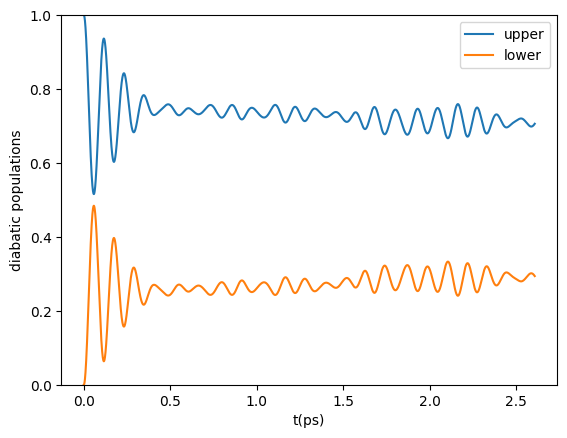

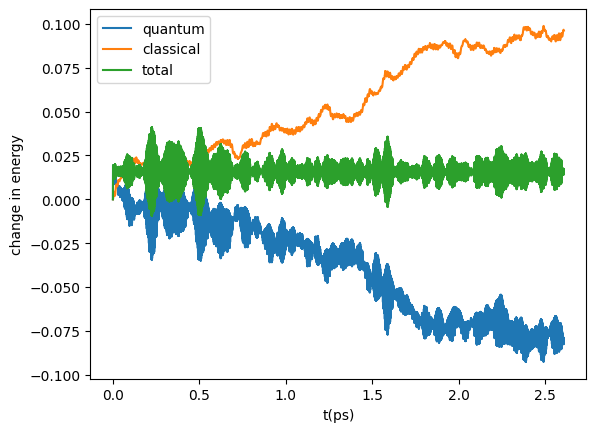

In [90]:
ntraj =  num_seeds
pops_mf = np.real(np.einsum('nii->ni',data_mf.data_dic['dm_db']))/ntraj
t_ps = data_mf.data_dic['t'] * 0.0260677 /ntraj
e_q = data_mf.data_dic['e_q']/ntraj
e_c = data_mf.data_dic['e_c']/ntraj
#bound1 = data_mf.data_dic['bound1']/ntraj
#bound2 = data_mf.data_dic['bound2']/ntraj
plt.plot(t_ps, pops_mf[:,0], label='upper')
plt.plot(t_ps, pops_mf[:,1], label='lower')
plt.ylabel('diabatic populations')
plt.xlabel('t(ps)')
plt.legend()
plt.ylim([0,1])
plt.savefig('pops_sb_mf.pdf')
plt.show()
#
#plt.plot(t_ps, bound1)
#plt.plot(t_ps, bound2)
#plt.plot(t_ps, e_q)
#plt.xlim([0,.1])
plt.show()
plt.plot(t_ps, np.real(e_q - e_q[0]), label='quantum')
plt.plot(t_ps, np.real(e_c - e_c[0]), label='classical')
plt.plot(t_ps, np.real(e_c - e_c[0] + e_q - e_q[0]), label='total')
plt.ylabel('change in energy')
plt.xlabel('t(ps)')
plt.legend()
plt.savefig('de_sb_mf.pdf')
plt.show()

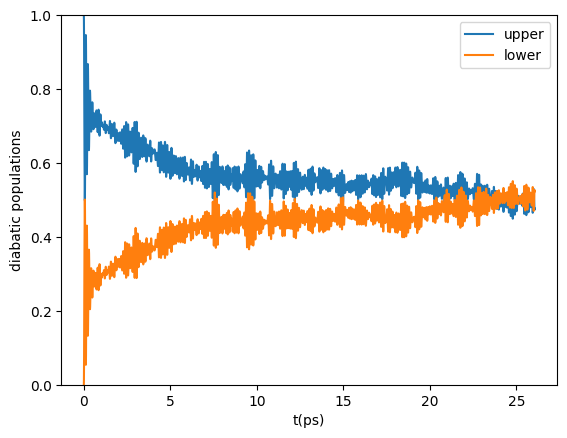

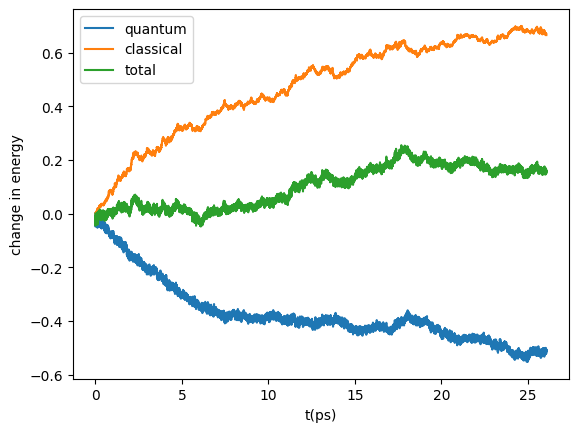

In [76]:
ntraj =  num_seeds
pops_mf = np.real(np.einsum('nii->ni',data_mf.data_dic['dm_db']))/ntraj
t_ps = data_mf.data_dic['t'] * 0.0260677 /ntraj
e_q = data_mf.data_dic['e_q']/ntraj
e_c = data_mf.data_dic['e_c']/ntraj
#bound1 = data_mf.data_dic['bound1']/ntraj
#bound2 = data_mf.data_dic['bound2']/ntraj
plt.plot(t_ps, pops_mf[:,0], label='upper')
plt.plot(t_ps, pops_mf[:,1], label='lower')
plt.ylabel('diabatic populations')
plt.xlabel('t(ps)')
plt.legend()
plt.ylim([0,1])
plt.savefig('pops_sb_mf.pdf')
plt.show()
#
#plt.plot(t_ps, bound1)
#plt.plot(t_ps, bound2)
#plt.plot(t_ps, e_q)
#plt.xlim([0,.1])
plt.show()
plt.plot(t_ps, np.real(e_q - e_q[0]), label='quantum')
plt.plot(t_ps, np.real(e_c - e_c[0]), label='classical')
plt.plot(t_ps, np.real(e_c - e_c[0] + e_q - e_q[0]), label='total')
plt.ylabel('change in energy')
plt.xlabel('t(ps)')
plt.legend()
plt.savefig('de_sb_mf.pdf')
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt   
# import the Spin-Boson Model Simulation Class
from qclab.models.spin_boson import SpinBosonModel
# import the mean-field dynamics Algorithm Class
from qclab.recipes import FewestSwitchesSurfaceHoppingDynamicsRecipe
# import the serial driver 
from qclab.drivers.serial_driver import dynamics_serial
# import the simulation data class
import qclab.simulation as simulation

input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
model = SpinBosonModel(input_params = input_params)

model.batch_size = 20
model.tmax=40
model.dt_output=0.1
model.dt=0.01

model.wf_db = np.zeros((model.num_states),dtype=complex)
model.wf_db[0] = 1

recipe_FSSH = FewestSwitchesSurfaceHoppingDynamicsRecipe(model)

num_seeds = 20*model.batch_size
seeds = np.arange(0, num_seeds)

data_fssh = dynamics_serial(recipe=recipe_FSSH, model = model, seeds = seeds, ncpus=1, data = simulation.Data())

100%|██████████| 20/20 [01:46<00:00,  5.30s/it]


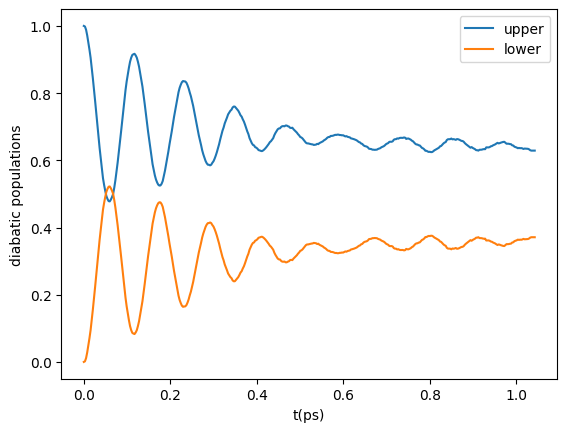

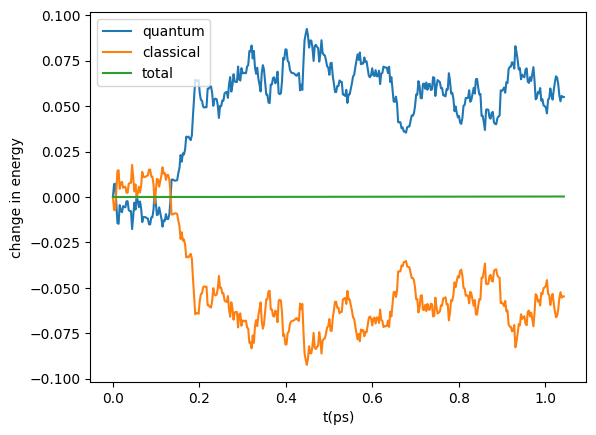

In [ ]:
ntraj =  num_seeds
pops_fssh = np.real(np.einsum('nii->ni',data_fssh.data_dic['dm_db']))/ntraj
t_ps = data_fssh.data_dic['t'] * 0.0260677 /ntraj
e_q = data_fssh.data_dic['e_q']/ntraj
e_c = data_fssh.data_dic['e_c']/ntraj

plt.plot(t_ps, pops_fssh[:,0], label='upper')
plt.plot(t_ps, pops_fssh[:,1], label='lower')
plt.ylabel('diabatic populations')
plt.xlabel('t(ps)')
plt.legend()
#plt.ylim([0,1])
plt.show()

plt.plot(t_ps, np.real(e_q - e_q[0]), label='quantum')
plt.plot(t_ps, np.real(e_c - e_c[0]), label='classical')
plt.plot(t_ps, np.real(e_c - e_c[0] + e_q - e_q[0]), label='total')
plt.ylabel('change in energy')
plt.xlabel('t(ps)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import qclab.simulation as simulation
from qclab.models.spin_boson import SpinBosonModel
from qclab.algorithms.mf import MeanFieldDynamics
#from qclab.algorithms.fssh import FewestSwitchesSurfaceHoppingDynamics
#from qclab.algorithms.cfssh import CoherentFewestSwitchesSurfaceHoppingDynamics
from qclab.drivers.ray_driver import dynamics_parallel_ray
from qclab.drivers.serial_driver import dynamics_serial

input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
model = SpinBosonModel(input_params = input_params)

model.batch_size = 200
model.tmax=int(1/0.0260677)+1
model.dt_output=0.01
model.dt=1/(10*model.w[-1])

model.wf_db = np.zeros((model.num_states),dtype=complex)
model.wf_db[0] = 1

num_seeds = 100*model.batch_size
seeds = np.arange(0, num_seeds)

data_spin_boson_mf = dynamics_serial(MeanFieldDynamics, model, seeds)

100%|██████████| 100/100 [12:06<00:00,  7.27s/it]


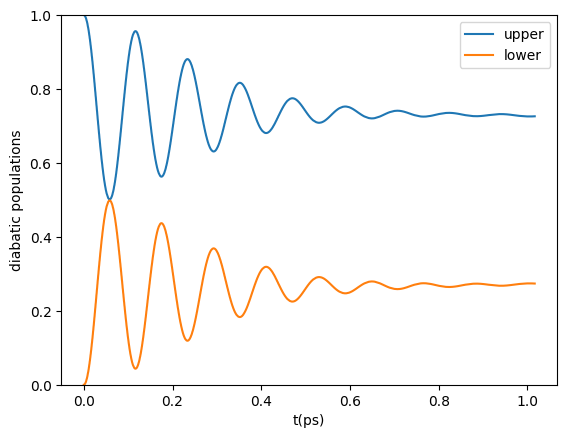

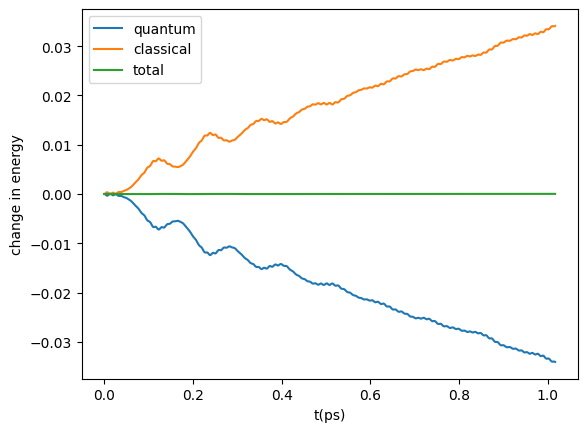

In [ ]:
ntraj =  num_seeds
pops_mf = np.real(np.einsum('nii->ni',data_spin_boson_mf.data_dic['dm_db']))/ntraj
t_ps = data_spin_boson_mf.data_dic['t'] * 0.0260677 /ntraj
e_q = data_spin_boson_mf.data_dic['e_q']/ntraj
e_c = data_spin_boson_mf.data_dic['e_c']/ntraj

plt.plot(t_ps, pops_mf[:,0], label='upper')
plt.plot(t_ps, pops_mf[:,1], label='lower')
plt.ylabel('diabatic populations')
plt.xlabel('t(ps)')
plt.legend()
plt.ylim([0,1])
plt.savefig('pops_sb_mf.pdf')
plt.savefig('pops_sb_mf.svg')
plt.savefig('pops_sb_mf.png')
plt.show()

plt.plot(t_ps, e_q - e_q[0], label='quantum')
plt.plot(t_ps, e_c - e_c[0], label='classical')
plt.plot(t_ps, e_c - e_c[0] + e_q - e_q[0], label='total')
plt.ylabel('change in energy')
plt.xlabel('t(ps)')
plt.legend()
plt.savefig('de_sb_mf.pdf')
plt.savefig('de_sb_mf.svg')
plt.savefig('de_sb_mf.png')
plt.show()

In [ ]:
input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
model = SpinBosonModel(input_params = input_params)

model.batch_size = 200
model.tmax=int(1/0.0260677)+1
model.dt_output=0.01
model.dt=1/(10*model.w[-1])

model.wf_db = np.zeros((model.num_states),dtype=complex)
model.wf_db[0] = 1


nprocs = 8
num_seeds = 100*model.batch_size
seeds = np.arange(0, num_seeds)
data_mf = dynamics_parallel_ray(MeanFieldDynamics, model, seeds, nprocs)#, simulation.Data())

2024-07-19 08:50:45,275	INFO worker.py:1771 -- Started a local Ray instance.
  0%|          | 0/13 [00:00<?, ?it/s](raylet) [2024-07-19 08:50:55,193 E 1519267 1519289] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-19_08-50-43_703275_1518367 is over 95% full, available space: 17947889664; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-19 08:51:05,220 E 1519267 1519289] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-19_08-50-43_703275_1518367 is over 95% full, available space: 17947828224; capacity: 493949374464. Object creation will fail if spilling is required.
  8%|▊         | 1/13 [00:23<04:42, 23.52s/it](raylet) [2024-07-19 08:51:15,267 E 1519267 1519289] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-19_08-50-43_703275_1518367 is over 95% full, available space: 17947795456; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-19 08:51:25,286 E 1519267 

KeyboardInterrupt: 

(raylet) [2024-07-19 08:54:55,827 E 1519267 1519289] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-19_08-50-43_703275_1518367 is over 95% full, available space: 17946300416; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-19 08:55:05,838 E 1519267 1519289] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-19_08-50-43_703275_1518367 is over 95% full, available space: 17946234880; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-19 08:55:15,847 E 1519267 1519289] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-19_08-50-43_703275_1518367 is over 95% full, available space: 17946112000; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-19 08:55:25,855 E 1519267 1519289] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-19_08-50-43_703275_1518367 is over 95% full, available space: 17946103808; capacity: 49394

In [ ]:
input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
model = SpinBosonModel(input_params = input_params)

model.batch_size = 20
model.tmax=int(1/0.0260677)+1
model.dt_output=0.01
model.dt=1/(10*model.w[-1])

model.wf_db = np.zeros((model.num_states),dtype=complex)
model.wf_db[0] = 1


nprocs = 8
num_seeds = 10*model.batch_size
seeds = np.arange(0, num_seeds)
data_fssh = dynamics_parallel_ray(FewestSwitchesSurfaceHoppingDynamics, model, seeds, nprocs, simulation.Data())

2024-07-15 13:53:44,222	INFO worker.py:1771 -- Started a local Ray instance.
  0%|          | 0/2 [00:00<?, ?it/s](raylet) [2024-07-15 13:53:54,149 E 1165999 1166021] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-53-42_635297_1164054 is over 95% full, available space: 18829627392; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-15 13:54:04,177 E 1165999 1166021] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-53-42_635297_1164054 is over 95% full, available space: 18829406208; capacity: 493949374464. Object creation will fail if spilling is required.
100%|██████████| 2/2 [00:33<00:00, 16.53s/it]


In [ ]:
input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
sim = SpinBosonModel(input_params = input_params)

sim.batch_size = 20 # sim.batch_size
sim.tmax=int(1/0.0260677)+1
sim.dt_output=0.01
sim.dt=1/(10*sim.w[-1])

sim.wf_db = np.zeros((sim.num_states),dtype=complex)
sim.wf_db[0] = 1


nprocs = 8
num_seeds = 10*sim.batch_size
seeds = np.arange(0, num_seeds)
data_cfssh = dynamics_parallel_ray(CoherentFewestSwitchesSurfaceHoppingDynamics, sim, seeds, nprocs, simulation.Data())

2024-07-15 13:51:00,791	INFO worker.py:1771 -- Started a local Ray instance.
  0%|          | 0/2 [00:00<?, ?it/s](raylet) [2024-07-15 13:51:10,714 E 1165246 1165269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-50-59_102509_1164054 is over 95% full, available space: 18830163968; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-15 13:51:20,737 E 1165246 1165269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-50-59_102509_1164054 is over 95% full, available space: 18830848000; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-15 13:51:30,750 E 1165246 1165269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-50-59_102509_1164054 is over 95% full, available space: 18830839808; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-15 13:51:40,773 E 1165246 1165269] (raylet) file_system_monitor.cc:111: /

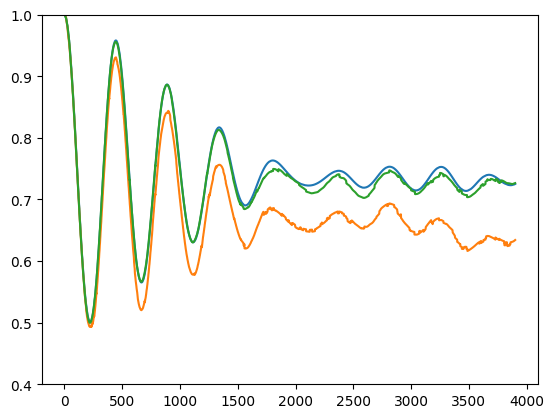

In [ ]:
pops_fssh = np.real(np.einsum('nii->ni',data_fssh.data_dic['dm_db']))
ntraj = np.sum(pops_fssh[0])
pops_fssh = pops_fssh/ntraj

pops_mf = np.real(np.einsum('nii->ni',data_mf.data_dic['dm_db']))
ntraj = np.sum(pops_mf[0])
pops_mf = pops_mf/ntraj

pops_cfssh = np.real(np.einsum('nii->ni',data_cfssh.data_dic['dm_db']))
ntraj = np.sum(pops_cfssh[0])
pops_cfssh = pops_cfssh/ntraj

plt.plot(pops_mf[:,0])
plt.plot(pops_fssh[:,0])
plt.plot(pops_cfssh[:,0])
plt.ylim([0.4,1])
plt.show()